### Possible improvements:
1) check "choose_prob" method for useless calls, as they rely on the slow np.linalg library

2) consider improving Pr0fromScipy calls (eventually re/move the dimensional check from there)

3) performances for 2+ parameters are poor if Trotterization is OFF... reason not yet clear

...

In [18]:
%matplotlib inline

import qinfer as qi
#import qutip as qt
import numpy as np
import scipy as sp
from IPython.display import display, Math, Latex
from functools import partial
import matplotlib.pyplot as plt
import importlib as imp

In [19]:
import datetime
import os as os
import time as time

In [20]:
import logging as logging
import sys

%run LoggingCode.py

In [21]:
# tell the user where files will be saved
dire = os.getcwd()
dire = dire+"/tests/T"
dire = os.path.normpath(dire)
print('Files will be saved in:')
print(dire)

Files will be saved in:
C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\Projects\CU4 chip\QHLandD\MultiPar_GenSim cleanup\tests\T


In [22]:
from Norms import *
from IOfuncts import *
from EvalLoss import *

import ProbeStates as pros
import multiPGH as mpgh
import GenSim_IQLE as gsi
import Evo as evo

In [23]:
imp.reload(pros)
imp.reload(mpgh)
imp.reload(gsi)
imp.reload(evo)

<module 'Evo' from 'C:\\Users\\ag15141\\Local Documents\\Cloud\\Dropbox (Qsim)\\Projects\\CU4 chip\\QHLandD\\MultiPar_GenSim cleanup\\Evo.py'>

# Results from trivial step-by-step implementation in 2 parameters case


In [44]:
probecounter = 0

#oplist=np.array([evo.sigmay(), evo.sigmax()])
oplist=np.array([evo.sigmaz()])
oplist=np.dot(1.0, oplist)
print('Oplist: ' + repr(oplist))

#true_params = np.array([[0.3, 0.6]])
true_params = np.array([[0.7]])
print('Chosen true_params: ' + str(true_params))

#Listing eigenvectors
# eiglist = pros.list_randomeig(oplist)
# eiglist = np.append(eiglist, np.array([1, 0]))
# eiglist = np.reshape(eiglist, [len(oplist)+1,2])
# print('Chosen probestates: ' + repr(eiglist))

#eiglist=sp.absolute(sp.linalg.orth(oplist[0]))
#print('Chosen probestates: ' + repr(eiglist))

probestate = evo.plus() # np.array([1, 0])
# probestate=pros.choose_probe(oplist,true_params)
print('Chosen probestate: ' + str(probestate))

sigw = 0.3
siga = 0.3

# prior = qi.MultivariateNormalDistribution(
#      [true_params[0, 0] + sigw/3, true_params[0, 1]-siga/3], [[sigw **2, 0], [0, siga **2]])
prior = qi.UniformDistribution([0., 1])


model = gsi.GenSim_IQLE(oplist=oplist, modelparams=true_params, probecounter = 0, probelist= [probestate], solver='scipy', trotter=True)


n_particles = 300
n_experiments = 100

updater = qi.SMCUpdater(model, n_particles, prior, resample_thresh=0.5, resampler = qi.LiuWestResampler(a=0.95), debug_resampling=True)

inv_field = [item[0] for item in model.expparams_dtype[1:] ]
print('Inversion fields are: ' + str(inv_field))
heuristic = mpgh.multiPGH(updater, oplist, inv_field=inv_field)
print('Heuristic output:' + repr(heuristic()))

expparams = np.empty((1, ), dtype=model.expparams_dtype)

print('Initialization Ready')

Oplist: array([[[ 1.,  0.],
        [ 0., -1.]]])
Chosen true_params: [[ 0.7]]
Chosen probestate: [ 0.70710678  0.70710678]
Inversion fields are: ['w_1']
Heuristic output:array([(6.6531707422227155, 0.4507630698018188)], 
      dtype=[('t', '<f8'), ('w_1', '<f8')])
Initialization Ready


In [45]:
# counter timestamp to avoid replacement
timestamp = str(datetime.datetime.now()).split('.')[0]
timestamp = "_"+timestamp.replace(" ", "_")
timestamp = timestamp.replace(":", ".")

# probecounter for the choice of the state
probecounter = 0

track_loss = np.empty(n_experiments)
track_cov = np.empty(n_experiments)
track_time = np.empty(n_experiments)

track_particle_locs = np.empty([n_particles, len(true_params[0]), n_experiments])
track_particle_wght = np.empty([n_particles, n_experiments])

start=time.clock()


for idx_experiment in range(n_experiments):
    
    experiment = heuristic()
    #print('Chosen experiment: ' + repr(experiment))
    
    if idx_experiment == 0:
        print('Initial time selected > ' + str(experiment[0][0]))
    if idx_experiment == n_experiments-1:
        print('Final time selected > ' + str(experiment[0][0]))
    
    track_time[idx_experiment] = experiment[0][0]
    
    datum = model.simulate_experiment(true_params, experiment)
    #print(repr(datum))
    updater.update(datum, experiment)
    #heuristic = mpgh.multiPGH(updater, oplist, inv_field=inv_field)
    
    track_cov[idx_experiment] = np.linalg.norm(updater.est_covariance_mtx())
    
    track_particle_locs[:, :, idx_experiment] = updater.particle_locations
    track_particle_wght[:, idx_experiment] = updater.particle_weights

    new_eval = updater.est_mean()
    
    new_loss = eval_loss(model, new_eval, true_params)
    track_loss[idx_experiment] = new_loss[0]
    
end=time.clock()
print('elapsed time: ' + str(end-start))

Initial time selected > 2.54918702418


qinfer.smc - DEBUG - Resampling changed mean by [ 0.0064331]. Norm change in cov: 0.000324779401046027.
qinfer.smc - DEBUG - Resampling changed mean by [ 0.00907568]. Norm change in cov: 0.003943218567128981.
qinfer.smc - DEBUG - Resampling changed mean by [ 0.00224645]. Norm change in cov: 1.2712012110949189e-05.
qinfer.smc - DEBUG - Resampling changed mean by [-0.00020617]. Norm change in cov: 1.852941808333508e-05.
qinfer.smc - DEBUG - Resampling changed mean by [ 0.00042385]. Norm change in cov: 5.218430597914159e-05.
qinfer.smc - DEBUG - Resampling changed mean by [ 0.00045658]. Norm change in cov: 2.107480651974969e-05.
qinfer.smc - DEBUG - Resampling changed mean by [ 0.00078017]. Norm change in cov: 9.093491376621632e-06.
qinfer.smc - DEBUG - Resampling changed mean by [-0.00082642]. Norm change in cov: 5.90791402399482e-06.
qinfer.smc - DEBUG - Resampling changed mean by [ 0.00186866]. Norm change in cov: 7.826082685519209e-05.
qinfer.smc - DEBUG - Resampling changed mean by [

Final time selected > 235599.416251
elapsed time: 18.844020360025752


Files to output:
C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\Projects\CU4 chip\QHLandD\MultiPar_GenSim cleanup\tests\T_2017-05-26_16.00.02_Fig_QL_CovNorm_Npars_1_Nexp_100_Nparts_300.pdf


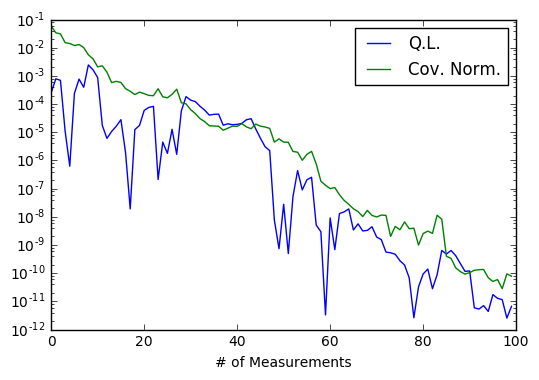

In [46]:
plt.semilogy(track_loss, label='Q.L.')
plt.semilogy(track_cov, label='Cov. Norm.')
plt.legend()
plt.xlabel('# of Measurements')

filename = dire+str(timestamp)+"_Fig_QL_CovNorm_Npars_"+str(len(true_params[0]))+"_Nexp_"+str(n_experiments)+"_Nparts_"+str(n_particles)+".pdf"
print("Files to output:\n" + str(filename))

#plt.savefig(filename)

plt.show()

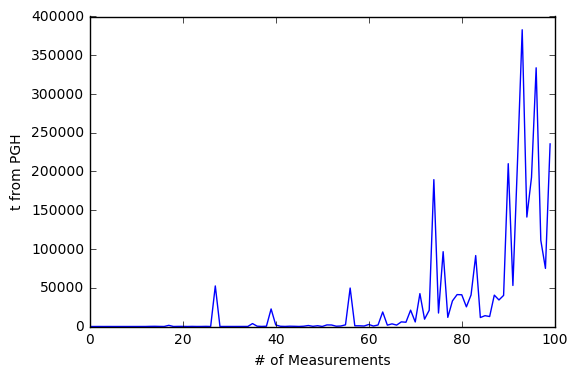

In [47]:
plt.plot(track_time)
plt.xlabel('# of Measurements')
plt.ylabel('t from PGH')

plt.show()

In [48]:
timestep = 0

plt.scatter(track_particle_locs[:,0,timestep], track_particle_locs[:,1,timestep], c=track_particle_wght[:,timestep], cmap=plt.cm.RdYlGn)
filefigname1 = dire+str(timestamp)+"With_Trotter"+"_Distro_particles"+"_SteNum_"+str(timestep)+"_Npars_"+str(len(true_params[0]))+"_Nexp_"+str(n_experiments)+"_Nparts_"+str(n_particles)+".pdf"
plt.savefig(filefigname1)
plt.show()

IndexError: index 1 is out of bounds for axis 1 with size 1

In [18]:
filename1 = dire+str(timestamp)+"_particles"+"_Npars_"+str(len(true_params[0]))+"_Nexp_"+str(n_experiments)+"_Nparts_"+str(n_particles)+".csv"
filename2 = dire+str(timestamp)+"_weights"+"_Npars_"+str(len(true_params[0]))+"_Nexp_"+str(n_experiments)+"_Nparts_"+str(n_particles)+".csv"

print("Files to output:\n" + str(filename1) + "\n" + str(filename2))

Files to output:
/Users/raf/Dropbox (Qsim)/Projects/CU4 chip/QHLandD/MultiPar_GenSim cleanup/tests/T_2017-05-14_10.56.28_particles_Npars_2_Nexp_600_Nparts_1000.csv
/Users/raf/Dropbox (Qsim)/Projects/CU4 chip/QHLandD/MultiPar_GenSim cleanup/tests/T_2017-05-14_10.56.28_weights_Npars_2_Nexp_600_Nparts_1000.csv


In [19]:
writeToFile3d(filename1, track_particle_locs)
writeToFile2d(filename2, track_particle_wght)

In [32]:
dire

'/Users/raf/Dropbox (Qsim)/Projects/CU4 chip/QHLandD/MultiPar_GenSim cleanup\\tests\\T'

# Results from qi.perftest


In [12]:
probecounter = 0

oplist=np.array([evo.sigmay(), evo.sigmax()])
#oplist=np.array([evo.sigmaz()])
oplist=np.dot(1.0, oplist)
print('Oplist: ' + repr(oplist))

true_params = np.array([[0.3, 0.6]])
#true_params = np.array([[0.7]])
print('Chosen true_params: ' + str(true_params))

#Listing eigenvectors
# eiglist = pros.list_randomeig(oplist)
# eiglist = np.append(eiglist, np.array([1, 0]))
# eiglist = np.reshape(eiglist, [len(oplist)+1,2])
# print('Chosen probestates: ' + repr(eiglist))

#eiglist=sp.absolute(sp.linalg.orth(oplist[0]))
#print('Chosen probestates: ' + repr(eiglist))

probestate=pros.choose_probe(oplist,true_params)
print('Chosen probestate: ' + str(probestate))

sigw = 0.3
siga = 0.3

prior = qi.MultivariateNormalDistribution(
     [true_params[0, 0] + sigw/3, true_params[0, 1]-siga/3], [[sigw **2, 0], [0, siga **2]])
# prior = qi.UniformDistribution([0., 1])


model = gsi.GenSim_IQLE(oplist=oplist, modelparams=true_params, probecounter = 0, probelist= [probestate], solver='scipy', trotter=True)


n_particles = 300
n_experiments = 300


extra_updater_args={'resample_thresh': 0.5, 'resampler': qi.LiuWestResampler(a=0.95), 'debug_resampling': True}
updater = qi.SMCUpdater(model, n_particles, prior, **extra_updater_args)

inv_field = [item[0] for item in model.expparams_dtype[1:] ]
print('Inversion fields are: ' + str(inv_field))
heuristic = mpgh.multiPGH(updater, oplist, inv_field=inv_field)
print('Heuristic output:' + repr(heuristic()))

expparams = np.empty((1, ), dtype=model.expparams_dtype)

print('Initialization Ready')

Oplist: array([[[ 0.+0.j,  0.-1.j],
        [ 0.+1.j,  0.+0.j]],

       [[ 0.+0.j,  1.+0.j],
        [ 1.+0.j,  0.+0.j]]])
Chosen true_params: [[ 0.3  0.6]]
Chosen probestate: [ 0.9472136+0.2236068j  0.0527864-0.2236068j]
Inversion fields are: ['w_1', 'w_2']
Heuristic output:array([(1.3268625344344318, 0.7978591672841162, 0.13000019918003491)], 
      dtype=[('t', '<f8'), ('w_1', '<f8'), ('w_2', '<f8')])
Initialization Ready


In [13]:
start = time.clock()

perf = qi.perf_test(model=model, n_particles=n_particles, prior=prior,
        n_exp=n_experiments, true_mps = true_params, heuristic_class=partial(mpgh.multiPGH, inv_field=inv_field, t_field='t'), 
                    extra_updater_args = extra_updater_args)

end=time.clock()
print('elapsed time: ' + str(end-start))

Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [-0.00081456  0.00249908]. Norm change in cov: 0.0055968084372235456.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [-0.03095397  0.01634325]. Norm change in cov: 0.007218519797061875.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [-0.00920709  0.02083949]. Norm change in cov: 0.005600356193710194.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [-0.0258048  -0.01399422]. Norm change in cov: 0.0014771616669812912.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [-0.00184579 -0.00656916]. Norm change in cov: 0.0014185839305345567.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [-0.00714717 -0.00638797]. Norm change in cov: 0.003520297027713937.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [ 0.00242195 -0.00382663]. Norm change in cov: 0.0019354941775681742.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [ 0.00129871 -0.00073769]. Norm change in cov: 0.0009924771008645217.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [-0.00996171 -0.00100685]. Norm change in cov: 0.003421089946056645.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [-0.00515193  0.00352457]. Norm change in cov: 0.00134090368903482.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [ 0.00051994  0.00023535]. Norm change in cov: 0.0012125710767038683.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [  6.10825304e-05   3.69532509e-03]. Norm change in cov: 0.00015721918550818745.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [-0.00041038  0.00046839]. Norm change in cov: 0.0001422422602897999.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [-0.00116985 -0.00074085]. Norm change in cov: 0.00013599359649275422.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [  8.13097264e-05   4.90986830e-04]. Norm change in cov: 0.0001061193374815472.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [ 0.00052745  0.00102322]. Norm change in cov: 0.0001129057683390815.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [-0.00066031 -0.00051913]. Norm change in cov: 1.9474143988482196e-05.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [ -1.06037217e-03  -6.71424402e-05]. Norm change in cov: 0.0001295343746593825.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [ 0.00046367 -0.00067586]. Norm change in cov: 9.400556090546169e-05.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [-0.00095962 -0.00042402]. Norm change in cov: 5.3610174032371945e-05.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [ 0.00033474  0.00026128]. Norm change in cov: 1.1726263469990727e-05.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [-0.00030223 -0.00040582]. Norm change in cov: 1.8779936888376742e-05.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [-0.00023117  0.00016885]. Norm change in cov: 1.5553556745875096e-06.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [  1.93301626e-04  -2.68792907e-05]. Norm change in cov: 2.223091056679283e-06.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [ 0.00018041  0.00018221]. Norm change in cov: 1.2606885490651617e-06.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [-0.00012379  0.00012376]. Norm change in cov: 1.755212537558403e-06.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [ -2.98278165e-04   4.29217450e-06]. Norm change in cov: 3.290643791590942e-07.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [ 0.00011862 -0.00011156]. Norm change in cov: 9.852381119095162e-07.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [  6.77159021e-05   5.74983302e-05]. Norm change in cov: 6.580736510207696e-07.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [ -1.87105892e-04  -3.81297533e-05]. Norm change in cov: 5.777009395873054e-07.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [ -1.34506610e-04   7.31497764e-05]. Norm change in cov: 1.3401164004996021e-06.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [ 0.00020903  0.0001266 ]. Norm change in cov: 5.530476312760705e-07.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [-0.00027013 -0.00010065]. Norm change in cov: 2.00541551107077e-06.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [  1.08279189e-04   3.13677465e-05]. Norm change in cov: 2.758072070155656e-07.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [ -1.39155984e-04   4.41717637e-05]. Norm change in cov: 5.399461524369819e-07.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [ -7.93471972e-05  -2.09189073e-05]. Norm change in cov: 1.0127415610361786e-06.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [  4.96479211e-04   3.12522294e-05]. Norm change in cov: 2.1454882471081452e-06.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [-0.00024623 -0.00019203]. Norm change in cov: 2.612724591706088e-07.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [  1.81927385e-04   7.60068993e-05]. Norm change in cov: 8.452195823826079e-07.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [ -5.70362118e-05  -1.06679468e-04]. Norm change in cov: 4.15515186220473e-07.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [ -4.76970893e-05  -1.04132620e-05]. Norm change in cov: 3.164925066730262e-07.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [  4.13149487e-05   1.07378243e-05]. Norm change in cov: 1.2365233427049467e-07.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [ -7.65157836e-06   4.07356571e-05]. Norm change in cov: 4.901829721256805e-08.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [  1.98391662e-05   6.79831151e-06]. Norm change in cov: 2.5451791480201224e-08.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [  1.63436763e-05   2.18306266e-06]. Norm change in cov: 1.765276002216651e-08.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [  2.63194293e-05  -2.83132720e-05]. Norm change in cov: 1.3592933724377597e-08.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [  8.22398900e-06  -1.02574985e-05]. Norm change in cov: 1.5851110256273484e-08.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [  7.15941983e-06   9.31392524e-06]. Norm change in cov: 4.771766467703968e-09.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [ -1.11770501e-05   3.63609557e-06]. Norm change in cov: 9.451899150733733e-10.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [  2.87427087e-06   4.38387687e-06]. Norm change in cov: 7.201582666160891e-10.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [ -1.45173580e-06   2.73357221e-06]. Norm change in cov: 5.325576414386842e-10.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [ -7.02167038e-06  -1.00234965e-06]. Norm change in cov: 3.318489732570281e-10.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [  9.79495181e-07  -1.65327691e-06]. Norm change in cov: 1.6322888058380426e-10.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [  1.83420537e-06  -2.46939834e-07]. Norm change in cov: 5.4640521765037514e-11.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [ -4.17788672e-07  -2.55683674e-06]. Norm change in cov: 6.950579968418899e-11.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [  8.85104104e-07  -5.90843022e-07]. Norm change in cov: 3.461720144882157e-11.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [  3.26060745e-07  -7.39431503e-07]. Norm change in cov: 1.7984772337879532e-11.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [  4.54348108e-07   4.49330621e-07]. Norm change in cov: 2.0960793579031883e-11.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [ -3.10140384e-07  -1.81706808e-07]. Norm change in cov: 3.052538055745146e-12.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [ -2.27285551e-07   1.17293560e-07]. Norm change in cov: 3.3708769497181634e-12.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [  2.71878070e-09   5.52721763e-08]. Norm change in cov: 5.710921263829758e-13.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [ -6.59675577e-08   5.52989483e-08]. Norm change in cov: 3.264537299300597e-13.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [ -1.05519545e-07   2.65678214e-08]. Norm change in cov: 9.13157618690162e-13.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [ -1.91558043e-07  -2.19025372e-08]. Norm change in cov: 1.1219731913648784e-12.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [ -7.51908592e-08   3.22308034e-08]. Norm change in cov: 1.175014026397302e-13.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [ -3.62476600e-08   8.99382991e-08]. Norm change in cov: 1.0271862026079369e-13.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [  5.60149445e-08   1.65406954e-08]. Norm change in cov: 1.2952170215394533e-13.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [ -7.05227549e-08  -1.22504095e-08]. Norm change in cov: 4.0924599799478955e-13.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [ -1.32522264e-08   1.59494472e-08]. Norm change in cov: 3.3272467300304665e-14.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [  9.53935020e-09   6.02313199e-09]. Norm change in cov: 2.5508812317227402e-14.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [  6.04804040e-09   6.79696033e-09]. Norm change in cov: 2.9590945392394222e-15.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian


qinfer.smc - DEBUG - Resampling changed mean by [ -2.08877954e-09  -1.03377938e-08]. Norm change in cov: 2.755780643793651e-15.


Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
Calling the false Hamiltonian
elapsed time: 37.18885661080074


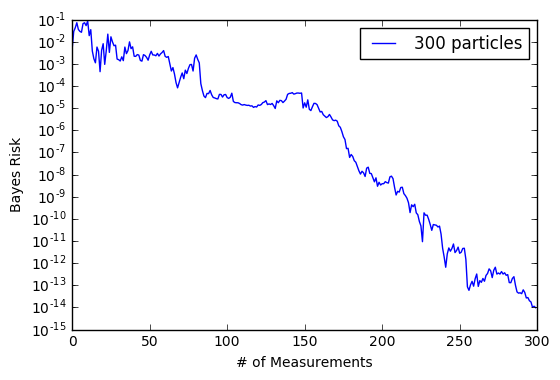

In [17]:
bayes_risk = perf['loss']

plt.semilogy(bayes_risk, label='{} particles'.format(n_particles))

plt.xlabel('# of Measurements')
plt.ylabel('Bayes Risk')
plt.legend()